In [1]:
import pandas as pd
import seaborn as sns
import re

In [2]:
data = pd.read_json("data_analysis.json")


In [3]:
data.head()

,address,category_code,city,headcount,name,phone,revenue,state,time_in_business,zip
0,10085 SCRIPPS RANCH CT STE A,44420000,SAN DIEGO,50 to 99,AMD CUSTOM,3123628000,$20 to 50 Million,CA,10+ years,92131
1,2566 SHALLOWFORD RD NE STE 104 # 302,31490000,ATLANTA,1 to 4,Real Hope Real Estate Inc,None,"Less Than $500,000",GA,10+ years,30345
2,212 E MAIN ST,53120000,NEOSHO,1 to 4,Jimmy Sexton Photography,4046331779,"Less Than $500,000",MO,10+ years,64850
3,6032 CHEROKEE DR,54000000,CINCINNATI,1 to 4,YOU'RE ART,4174513798,"Less Than $500,000",OH,10+ years,45243
4,1315 N WOOSTER AVE,54100000,STRASBURG,1 to 4,Hayberg Restoration Network LLC,5135612584,"$500,000 to $1 Million",OH,10+ years,44680


In [4]:
data.shape

(1000000, 10)

#### 1. Fill Rate

In [5]:
#  For each field, how many records have a value.
null_val  = []
not_null = []
fill_rate = []
for item in data.columns:
    miss_num  = data[item].isnull().values.sum()
    null_val.append(miss_num)
    not_null.append(len(data)-miss_num)
    fill_rate.append((len(data)-miss_num)/len(data))


In [6]:
df_fill =  pd.DataFrame(
    {'Number of null values': null_val,
     'Number of not null vaules': not_null,
     'Fill rate': fill_rate
    },index = data.columns)

In [7]:
df_fill

,Fill rate,Number of not null vaules,Number of null values
address,0.999986,999986,14
category_code,0.999986,999986,14
city,0.999986,999986,14
headcount,0.962352,962352,37648
name,0.999986,999986,14
phone,0.590889,590889,409111
revenue,0.943092,943092,56908
state,0.999986,999986,14
time_in_business,0.916125,916125,83875
zip,0.999988,999988,12


#### 2. True-Valued Fill Rate

Fields have several types of irrelevant values:"", " ", "0","none","null",0 

In [8]:
# Check if each field has inconsistent types
for col in data.columns:
    print(col, set([type(x) for x in data[col]]))

address {<class 'int'>, <class 'NoneType'>, <class 'str'>}
category_code {<class 'int'>, <class 'NoneType'>, <class 'str'>}
city {<class 'int'>, <class 'NoneType'>, <class 'str'>}
headcount {<class 'int'>, <class 'NoneType'>, <class 'str'>}
name {<class 'int'>, <class 'NoneType'>, <class 'str'>}
phone {<class 'int'>, <class 'NoneType'>, <class 'str'>}
revenue {<class 'int'>, <class 'NoneType'>, <class 'str'>}
state {<class 'int'>, <class 'NoneType'>, <class 'str'>}
time_in_business {<class 'int'>, <class 'NoneType'>, <class 'str'>}
zip {<class 'int'>, <class 'NoneType'>, <class 'str'>}


In [9]:
# For field that may have large cardility, we need to check carefully based on the meaning of field 
# For field that may have small cardility, we can use "set" to get the complete information of records

In [10]:
# Use "address" as an example
# Based on common sense, the number of words of address is unlikely to be 0 or 1
data_ad = data[data.address.notnull()].address

idx = []
for i in range(len(data_ad)):
    if isinstance(data_ad.iloc[i],str) and len(data_ad.iloc[i].split()) in [0,1]:
         idx.append(i)

In [11]:
data_ad.iloc[idx][0:10]

22062     null
33870     none
43516         
95603     null
96310     none
102461    none
114195        
137494    null
141320        
157640        
Name: address, dtype: object

In [12]:
irr_value = set(data_ad.iloc[idx])
irr_value

{'', ' ', '0', '2ND', 'none', 'null'}

In [16]:
# Based on the irrelevant records in "address", other records have the same probelm
def true_fill(field):
    data1 = data[data[field].notnull()][field]
    count = 0
    for i in range(len(data1)):
        if not isinstance(data1.iloc[i],str) or (isinstance(data1.iloc[i],str) and  data1.iloc[i] in irr_value ):
            count +=1
    return count

In [18]:
cc = []
for col in data.columns:
    cc.append(true_fill(col))
    


In [19]:
# subsract from total number of filled value
# store as the dataframe
true_fil = len(data)- np.array(cc)-np.array(null_val)
true_fil_rate = [ i/len(data) for i in true_fil]
df_tfill =  pd.DataFrame(
    {'Number of null values': null_val,
     'Number of irrelevant vaules': cc,
     'Number of true values': true_fil,
    "True-Valued Fill Rate": true_fil_rate
     },index = data.columns)

In [20]:
df_tfill

,Number of irrelevant vaules,Number of null values,Number of true values,True-Valued Fill Rate
address,89,14,999897,0.999897
category_code,76,14,999910,0.999910
city,91,14,999895,0.999895
headcount,79,37648,962273,0.962273
name,76,14,999910,0.999910
phone,91,409111,590798,0.590798
revenue,91,56908,943001,0.943001
state,90,14,999896,0.999896
time_in_business,77,83875,916048,0.916048
zip,98,12,999890,0.999890


#### 3. Cardinality

The term cardinality refers to the uniqueness of data values contained in a particular field of a database table. The lower the cardinality, the more duplicated elements in a column.

In [21]:
ng_val = set([""," ","0",0,"none","null",None])

In [22]:
def card(field):
    data1 = data[data[field].notnull()][field]
    card_n1 = len(set(data1))
    card_n2 = len(set(data1)-ng_val)
    
    return card_n1,card_n2
    


In [23]:
card1 = []
card2 = []
for col in data.columns:
    card1.append(card(col)[0])
    card2.append(card(col)[1])
    
    

In [24]:
df_card = pd.DataFrame(
    {'cardinality for all records': card1,
    'cardinality for good records': card2  
     },index = data.columns)

In [25]:
df_card

,cardinality for all records,cardinality for good records
address,892120,892114
category_code,1184,1178
city,13720,13714
headcount,15,9
name,890723,890717
phone,575154,575148
revenue,17,11
state,59,53
time_in_business,11,5
zip,26397,26391


#### 4. Something interesting

- Inconsistent zip code entry 

In [26]:
# get rid of invalid entries
idx_zip = []
for i in range(len(data)):
    if data["zip"].ix[i] in ng_val:
        idx_zip.append(i)

# Extract the entries with inconsistent length of zip code
data_zip = data.drop(data.index[idx_zip])
l_zp = []
for i in range(len(data_zip)):
    if len(data_zip.zip.iloc[i]) != 5:
        l_zp.append(i)

In [27]:
data_zip.iloc[l_zp].head()    

,address,category_code,city,headcount,name,phone,revenue,state,time_in_business,zip
53,3 BOWLEN AVE # 1,54111000,SOUTHBRIDGE,1 to 4,Innovative Business Services,2122067348,"$500,000 to $1 Million",MA,10+ years,1550
57,10 ALLEN ST,44000000,HAMPDEN,1 to 4,Practical Pensions & Financial SVCS Inc,7819422199,"$500,000 to $1 Million",MA,10+ years,1036
60,1 MACKWORTH IS,52420000,FALMOUTH,10 to 19,Sweeney's Pavement Maintenance,None,"Less Than $500,000",ME,10+ years,4105
76,103 STATE ST,23000000,BOSTON,1 to 4,DERTECH LLC,None,"Less Than $500,000",MA,10+ years,2109
94,142 ELM ST,53120000,DOVER,20 to 49,"Rooney Insurance Agency, Inc.",None,None,NJ,10+ years,7801


- Relationship between headcount and revenue

In [28]:
# get rid of invalid entries
idx_head = []
for i in range(len(data)):
    if data["headcount"].ix[i] in ng_val:
        idx_head.append(i)

In [29]:
# get rid of invalid entries
idx_revenue = []
for i in range(len(data)):
    if data["revenue"].ix[i] in ng_val:
        idx_revenue.append(i)

In [30]:
# extract the valid entry
idx_comb = list(set(idx_head+idx_revenue))
data_hr = data.drop(data.index[idx_comb])


In [31]:
# extract number information from each entry
def digit(string):
    ll = [re.sub('[^0-9,]','',x ).replace(",", "") for x in string.split()]  
    ll2 = np.mean([int(y) for y in ll if y !=""])
    return ll2

In [32]:
# extract number information from each entry in revenur
def digit_2(string):
    global ans
    l = [re.sub('[^0-9,]','',x ).replace(",", "") for x in string.split()] 
    l2 = [int(y) for y in l if y !=""]
    if len(l2)==2 and l2[0] < l2[1]:
        ans = np.mean(l2)
    elif len(l2) ==2 and l2[0] == 500000:
        ans = np.mean([0.5,l2[1]])
    elif len(l2) ==1 and l2[0] == 500000:
        ans = 0.5
    elif len(l2) == 1 and l2[0] == 1:
        ans = 1000
    elif len(l2) == 1 and l2[0] == 500:
        ans = 500
    return ans

In [33]:
# get the mean of headcount and revenue for each entry
head = []
rev= []
for i in range(len(data_hr)):
    employ = digit(data_hr.headcount.iloc[i])
    profit = digit_2(data_hr.revenue.iloc[i])
    head.append(employ)
    rev.append(profit)
    

In [34]:
set(head), set(rev)

({2.5, 7.0, 14.5, 34.5, 74.5, 174.5, 374.5, 749.5, 1000.0},
 {0.5, 0.75, 7.5, 13.0, 15.0, 35.0, 75.0, 300.0, 500, 1000})

/Users/apple/anaconda/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


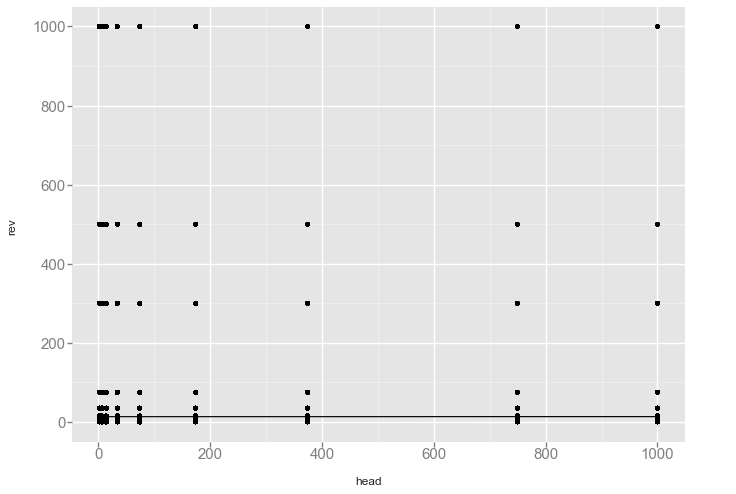

<ggplot: (-9223372036464839911)>

In [35]:
from ggplot import *
ggplot(aes(x='head', y='rev'), data=data_hr) + geom_point() + stat_smooth(colour='blue', span=0.2)

In [36]:
# add new column in dataframe
data_hr["employee"] = head
data_hr["rev"] = rev

# subset the dataframe with good value for time in business
data_hrt = data_hr[(data_hr.time_in_business == '6-10 years') | (data_hr.time_in_business == '10+ years') | (data_hr.time_in_business == '1-2 years') | (data_hr.time_in_business == '3-5 years') ]

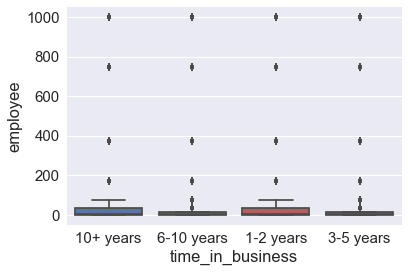

In [37]:
# boxplot 
import seaborn as sns
sns.boxplot(x='time_in_business', y='employee', data = data_hrt)

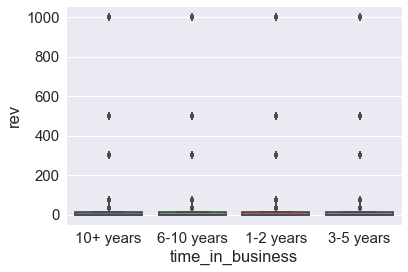

In [38]:
sns.boxplot(x='time_in_business', y='rev', data = data_hrt)

In [39]:
def IQR(x):
    return np.subtract(*np.percentile(x, [75, 25]))

In [40]:
mapped_funcs = {'employee': ('mean', IQR),'rev': ('mean', IQR)}

data_hrt.groupby(["time_in_business"]).agg(mapped_funcs)

rev         employee      
                       mean   IQR       mean   IQR
time_in_business                                  
1-2 years         13.502868  12.5  35.945091  32.0
10+ years         13.703908  12.5  34.682553  32.0
3-5 years         13.850123  12.5  34.087859  12.0
6-10 years        13.605027  12.5  34.753173  12.0

- Top popular cities and states for business

In [41]:
# get rid of invalid entries
idx_state = []
for i in range(len(data)):
    if data["state"].ix[i] in ng_val:
        idx_state.append(i)


data_state = data.drop(data.index[idx_state])

In [42]:
# sort state based on the occurences
from collections import Counter
from operator import itemgetter
state_list = data_state.state
state_count = dict(Counter(state_list))

sorted_state = sorted(state_count.items(), key=itemgetter(1),reverse=True)


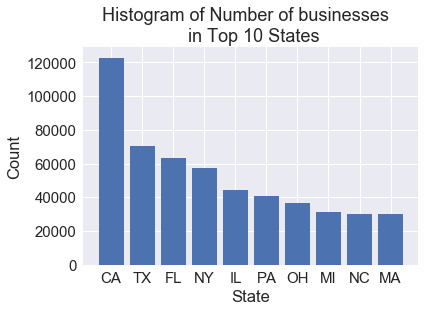

In [43]:
# Show the first ten popular states
state_top = sorted_state[0:10]
plt.bar(range(len(state_top)),[y for (x,y) in state_top])
plt.xticks(range(len(state_top)),[x for (x,y) in state_top])
plt.xlabel("State")
plt.ylabel("Count")
plt.title("Histogram of Number of businesses  \n in Top 10 States")
plt.show()

In [44]:
# subset the dataframe with state in CA
data_ca = data[data.state == "CA"]

In [45]:
# Find the top 5 popular business cities in CA 
city_list = data_ca.city
city_count = dict(Counter(city_list))
sorted_city = sorted(city_count.items(), key=itemgetter(1),reverse=True)
city_top = sorted_city[0:10]
c = [x for (x,y) in city_top]
num = [y for (x,y) in city_top]
df_city = pd.DataFrame(
    {'Number of Businesses': num
     },index = c)
df_city

,Number of Businesses
SAN DIEGO,5987
LOS ANGELES,5518
SAN FRANCISCO,4867
SAN JOSE,3215
SACRAMENTO,2466
IRVINE,2077
OAKLAND,1637
FRESNO,1488
LONG BEACH,1185
ANAHEIM,1182
